
# Setup of the environment

First, we are setting up our environment. We use an already compiled and 
packaged installation of HOOMD-blue and OpenMM. It is custom and comes with the plugins that are needed for PySAGES for advanced sampling. We copy it from google drive and install pysages for it. We also have a google collab that performs this installation for reference. This is however meant as an explanation of how to install these tools in your environment.

For your work, you can use the same environment if you want to work with google colab or install HOOMD-blue with the installation instructions from the [documentation](https://hoomd-blue.readthedocs.io/en/stable/installation.html) and use local Jupyter notebooks or python scripts.


In [1]:
%%bash

BASE_URL="https://drive.google.com/u/0/uc?id=1hsKkKtdxZTVfHKgqVF6qV2e-4SShmhr7&export=download"
wget -q --load-cookies /tmp/cookies.txt "$BASE_URL&confirm=$(wget -q --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate $BASE_URL -O- | sed -rn 's/.*confirm=(\w+).*/\1\n/p')" -O pysages-env.zip
rm -rf /tmp/cookies.txt

In [2]:
%env PYSAGES_ENV=/env/pysages

env: PYSAGES_ENV=/env/pysages


In [3]:
%%bash

mkdir -p $PYSAGES_ENV
unzip -qquo pysages-env.zip -d $PYSAGES_ENV

In [4]:
import os
import sys

ver = sys.version_info

sys.path.append(os.environ["PYSAGES_ENV"] + "/lib/python" + str(ver.major) + "." + str(ver.minor) + "/site-packages/")

# HOOMD-blue

For this part of the lecture, we introduce common molecular dynamics simulation engines. We start with HOOMD-blue which is an engine centered around the use of GPUs and developed with a python frontend. We are going to use version 2.X for this lecture. There is a new version available 3.X soon, that integrates even tighter with Python.

The homepage of HOOMD-blue can be found [here](https://glotzerlab.engin.umich.edu/hoomd-blue/). It is actively developed on github.com [here](https://github.com/glotzerlab/hoomd-blue) and has an excellent documentation [here](https://hoomd-blue.readthedocs.io/en/stable/package-hoomd.html).
Take some time and start exploring the documentation. It has good examples and explains different parts of the code well. In the context of this course it makes to focus on the core `hoomd` and the `hoomd.md` package.

In [5]:
import hoomd
import hoomd.md
import numpy as np

HOOMD-blue 2 operates with fixed context for the entire runtime, which also determines the available hardware. So our first step is to initialize this context.

In [6]:
hoomd.context.initialize("")

HOOMD-blue v2.9.7 CUDA (11.1) DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 01/26/2022
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the following GPU(s):
 [0]              Tesla T4  40 SM_7.5 @ 1.59 GHz, 15109 MiB DRAM, MNG


The output informs us about version information, essential for reproducibility.
And who are the authors of the software and which paper we should cite if we use HOOMD-blue for research.

After that, we are informed which hardware could be detected and HOOMD-blue is running on.

## Simulation of soft, coarse-grained polymers

We start with a familiar system. A melt of polymer chains densely fills the simulation box. The first step is to obtain the initial position of all chains.
One way to obtain this for HOOMD-blue is to generate a simulation snapshot and populate the snapshot with the values you are interested in.

Here we set up a system of 25 polymer chains with chain lengths $N=35$ each.

### Generation of initial conditions

In [7]:
n = 25
N = 35
L = 4
b0 = 0.75
snapshot = hoomd.data.make_snapshot(N=n*N,
                                    box=hoomd.data.boxdim(Lx=L, Ly=L, Lz=L),
                                    particle_types=['A'],
                                    bond_types=['backbone'])

Now we set up the initial position of each of the polymers. We do that, by randomly selecting the position of the first bead and growing the chain with the ideal gas distribution from there.

In [8]:
np_seed = 42
np_rng = np.random.default_rng(np_seed)

np_pos = np.zeros((n,N, 3))
for poly in range(n):
  np_pos[poly, 0] = np_rng.uniform(-L/2, L/2, (3,))
  for mono in range(1, N):
    # add gaussian distribution to previous bead pos.
    np_pos[poly, mono] = np_pos[poly, mono-1] + np_rng.normal(0, b0, (3,))
# HOOMD-blue does not know about polymers, so we reshape the positions to be a single array
np_pos = np_pos.reshape((n*N, 3))
print(np_pos)

[[ 1.09582419 -0.24448624  1.43439168]
 [ 1.80124773 -1.70776263  0.45775705]
 [ 1.89712803 -1.94494458  0.44515618]
 ...
 [ 9.29086361  5.27150454 -6.16330615]
 [ 9.98864701  4.69308192 -4.92027406]
 [ 9.47522999  4.18076307 -3.76725589]]


These positions are a great initial condition for beads, however, we have not respected the periodic boundary conditions with them so far. So we correct the periodic boundary conditions and remember which periodic image each particle belongs to.

In [9]:
box_L = np.asarray([L, L, L])
np_image = np.rint(np_pos / box_L).astype(int)
np_pos -= np_image * box_L

snapshot.particles.position[:] = np_pos
snapshot.particles.image[:] = np_image

print(snapshot.particles.image)
print(snapshot.particles.position)

[[ 0  0  0]
 [ 0  0  0]
 [ 0  0  0]
 ...
 [ 2  1 -2]
 [ 2  1 -1]
 [ 2  1 -1]]
[[ 1.0958242  -0.24448624  1.4343917 ]
 [ 1.8012477  -1.7077626   0.45775706]
 [ 1.897128   -1.9449446   0.4451562 ]
 ...
 [ 1.2908636   1.2715045   1.8366939 ]
 [ 1.988647    0.6930819  -0.9202741 ]
 [ 1.47523     0.18076307  0.23274411]]


We see that the first polymer was well within the box, but the last polymer was partly outside the box and has been folded back into the box.

Next are the bonds. We need to connect all the beads along with the individual polymers. In total we have $n(N-1)$ bonds.

In [10]:
snapshot.bonds.resize(n*(N-1))
# All bonds have the same interatin parameter, so they are of type `backbone` = 0
snapshot.bonds.typeid[:] = np.zeros(snapshot.bonds.N, dtype=int)
# Now we add the bonds as necessary
bonds = []
for poly in range(n):
  for mono in range(1, N):
    bond = np.asarray([mono-1, mono], dtype=int)
    # Shift to global particle index
    bond += poly*N
    bonds.append(bond)

snapshot.bonds.group[:] = bonds
print(snapshot.bonds.group)

[[  0   1]
 [  1   2]
 [  2   3]
 ...
 [871 872]
 [872 873]
 [873 874]]


As initial velocity, we choose the Maxwell-Boltzmann distribution.

In [11]:
snapshot.particles.velocity[:] = np_rng.normal(0, 1., (n*N, 3))
print(snapshot.particles.velocity)

[[ 0.21146016 -0.5520247  -0.15513313]
 [ 1.3530736   1.4662029  -0.8167932 ]
 [-0.04243381  0.09015683 -0.9862401 ]
 ...
 [-0.18561094  0.8488665  -0.69876343]
 [ 0.7886111   0.8222293   1.0549561 ]
 [ 0.140541    3.241259    1.0545337 ]]


We do not have to assign masses, since we leave all particles with the standard mass of 1.

### Simulation Setup

In [12]:
system = hoomd.init.read_snapshot(snapshot)

notice(2): Group "all" created containing 875 particles


For effective calculation of non-bonded forces, we need a Verlet-Neighbor list. We use the standard list here, which uses a grid for fast computation.

In [13]:
nl = hoomd.md.nlist.cell()

We need to define the interaction between the particles.
As non-bonded forces with choose the soft DPD potential, which has the shape $V(r) = A\cdot (r_\text{cut} - r) - 0.5 A/r_\text{cut} (r_\text{cut}^2 - r^2)$ for distances smaller than $r_\text{cut}$ and zero otherwise.
We use the conservative form here because we don't want the DPD thermostat, instead, we choose Nose-Hover later for the NVT ensemble. 

In [14]:
dpd = hoomd.md.pair.dpd_conservative(r_cut=1, nlist=nl)
dpd.pair_coeff.set("A", "A", A=5.0)

-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----


The next step is to setup a bonded potential for the interaction between beads along the chain. We choose the harmonic potential $V(r) = k/2 (r-r_0)^2$ with a resting length $r_0 = 0$ and k that corresponds to the chosen $k = 3/b_0^2$.

In [15]:
harmonic = hoomd.md.bond.harmonic()
harmonic.bond_coeff.set("backbone", k = 3./b0**2, r0=0)

Next, we choose an integrator and the time step. As an integrator, we use NVT integration, which means for HOOMD-blue two-step Velocity-Verlet integration with a Nose-Hover thermostat.

In [16]:
dt=1e-3
hoomd.md.integrate.mode_standard(dt=dt)
hoomd.md.integrate.nvt(hoomd.group.all(), kT=1.0, tau=1.0)

We do not only want to run the simulation, but we also would like to measure some properties during the simulation run. Hoomd has a logging system implemented that allows you to write observables to disk during the simulation run. Hoomd-blue has common observables implemented but lets user also specify their own observables. 

In [17]:
quantities_request = ['time', 'temperature',"pressure",'potential_energy','kinetic_energy', "bond_harmonic_energy"]
hoomd.analyze.log("obs.txt", quantities_request, period=100, overwrite=True)

We also want to log a trajectory, that contains all particle positions, bond information, etc. This is primarily useful for visualization and post-processing for more observables. We write the data in Hoomd's data format [gsd](https://gsd.readthedocs.io/en/stable/).

In [18]:
hoomd.dump.gsd("traj.gsd", 1e3, hoomd.group.all(), overwrite=True)

Now we can simulate a given number of time steps.

In [19]:
timesteps = 5e5
hoomd.run(timesteps)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 1 exclusions             : 50
notice(2): Particles with 2 exclusions             : 825
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 44508 / 500000 | TPS 4450.79 | ETA 00:01:42
Time 00:00:20 | Step 110726 / 500000 | TPS 6621.73 | ETA 00:00:58
Time 00:00:30 | Step 177734 / 500000 | TPS 6700.78 | ETA 00:00:48
Time 00:00:40 | Step 243990 / 500000 | TPS 6625.56 | ETA 00:00:38
Time 00:00:50 | Step 310469 / 500000 | TPS 6647.82 | ETA 00:00:28
Time 00:01:00 | Step 380635 / 500000 | TPS 7016.55 | ETA 00:00:17
Time 00:01:10 | Step 447642 / 500000 | TPS 6700.63 | ETA 00:00:07
Time 00:01:17 | Step 500000 / 500000 | TPS 7006.92 | ETA 00:00:00
Average TPS: 6453.57
---------
-- Neighborlist stats:
9343 normal updates / 1667 forced updates / 0 dangerous updates
n_neigh_min: 139 / n_neigh_max: 171 / n_neigh_avg: 154.247

At the end of the run, it is best practice to store the last configuration. This allows you to continue the simulation from the last step if it turns out, that you require more data for your analysis. Or if your wall time limitations on supercomputer resources.

In [20]:
hoomd.dump.gsd("final.gsd", None, hoomd.group.all(), overwrite=True, truncate=True)

# Analysis

## Visualization

We can use tools like Ovito[link text](https://www.ovito.org/) to visualize and inspect the full trajectory. Ovito has a free, open-source version that allows basic functions. A pro version is available but covers only functions that are beyond the scope of this course.

Ovito does not integrate seamlessly into this notebook, so we doing this offline.

## Plotting of data

However, during the simulation run, we stored some quantities in plain text format and we can use numpy and matplotlib to visualize this data.


In [21]:
!head obs.txt
import matplotlib.pyplot as plt

timestep, time, temp, pressure, Epot, Ekin, Ebond = np.loadtxt("obs.txt", skiprows=1, unpack=True)

timestep	time	temperature	pressure	potential_energy	kinetic_energy	bond_harmonic_energy
0	0.127615	0.9846927374	71.97658013	10104.68682	1290.932179	3803.499386
100	0.980527	1.584631204	80.65461269	9315.814083	2077.451509	3537.49191
200	1.096415	2.04815984	90.15203203	8677.17402	2685.13755	3030.238398
300	1.218211	2.36136644	98.86919961	8169.19078	3095.751403	2568.434959
400	1.324808	2.392420601	101.9783141	7939.047206	3136.463408	2342.503705
500	1.40571	2.172962337	98.39953245	7964.818651	2848.753624	2374.393763
600	1.509234	1.881094226	93.17900134	8053.429522	2466.11453	2504.378507
700	1.594541	1.646812396	89.58774466	8065.769023	2158.971051	2538.842966
800	1.696235	1.52140828	88.67597839	7938.160665	1994.566255	2415.379871


### Temperature

The Nose-Hover thermostat is supposed to keep the temperature at $k_BT=1$, so we can see if that is the case.

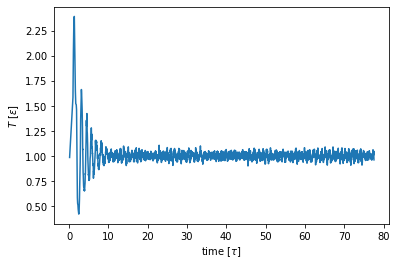

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel(r"time [$\tau$]")
ax.set_ylabel(r"$T$ [$\epsilon$]")
ax.plot(time, temp, label="instantanenous temeprature")

The observed oscillations are very common for the Nose-Hover algorithm. The time scale of these oscillations should be on the time scale of our friction time of the thermostat $\tau_\text{NH} =1 \tau$. And it is very crucial to equilibrate the system and its temperature before any measurements. Even as the oscillations do not decay completely in this example, we see, that the average temperature we set for the thermostat is achieved.

### Pressure

Since we perform NVT simulations the thermodynamic variable to volume $V$ pressure $p$ is a result of the simulations.
We can visualize this as a function of time.


94.546606907444 0.7454196924404413


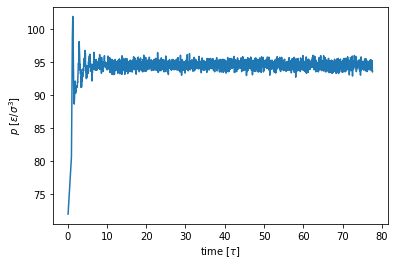

In [23]:
fig, ax = plt.subplots()
ax.set_xlabel(r"time [$\tau$]")
ax.set_ylabel(r"$p$ [$\epsilon/\sigma^3$]")
ax.plot(time, pressure, label="pressure")
print(pressure.mean(), pressure.std())

We also observe the unphysical effects of equilibration here at first. After that, we see how the pressure converges to a mean value. We expect this to be a thermal average of the pressure $\langle p \rangle$.

I print here simply the mean and std for reference for a real analysis we need to remove the equilibration period first and for the error estimation we need to perform a block analysis.

### Energy analysis

The last analysis we are interested in here is the evolution of energy.

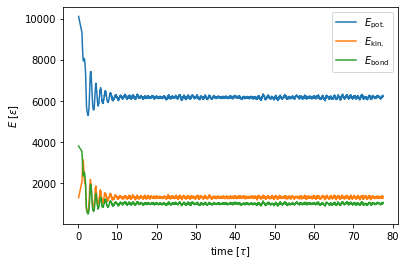

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel(r"time [$\tau$]")
ax.set_ylabel(r"$E$ [$\epsilon$]")
ax.plot(time, Epot, label=r"$E_\mathrm{pot.}$")
ax.plot(time, Ekin, label=r"$E_\mathrm{kin.}$")
ax.plot(time, Ebond, label=r"$E_\mathrm{bond}$")
ax.legend(loc="best")

We see that we start with a very high potential energy, also driven by overstretched bonds. This gets naturally traded for kinetic energy as the forces accelerate the particles. Here kicks the thermostat in and sheds the kinetic energy. This happens in oscillation until the equilibrium average potential and kinetic energies are reached.